Connected to .venv (Python 3.13.5)

In [31]:
"""
EDA_and_plot-experimentation_CS.ipynb
-------------------------------------
Explorative analysis and visualization of the LFW face dataset using PCA and Cosine Similarity.
Includes functions to plot images and confusion matrices for face recognition experiments.

This script is designed for educational and research purposes. It demonstrates how to:
- Load and preprocess the LFW face dataset
- Perform dimensionality reduction using PCA
- Visualize class distributions and image data
- Compute and visualize cosine similarity for face recognition
- Evaluate classification results with confusion matrices and reports

Author: Sergej Lembke
Date: 2025-08-19
"""

# --- Standard library imports ---
import math  # For grid layout calculations

# --- Third-party imports ---
import matplotlib.pyplot as plt  # For plotting
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation
import seaborn as sns  # For heatmap visualization
from imblearn.over_sampling import RandomOverSampler  # For class balancing
from sklearn.datasets import fetch_lfw_people  # LFW face dataset

<Axes: title={'center': 'LFW dataset: Distribution of samples per target class'}, xlabel='Number of pictures in dataset', ylabel='Sum of people'>

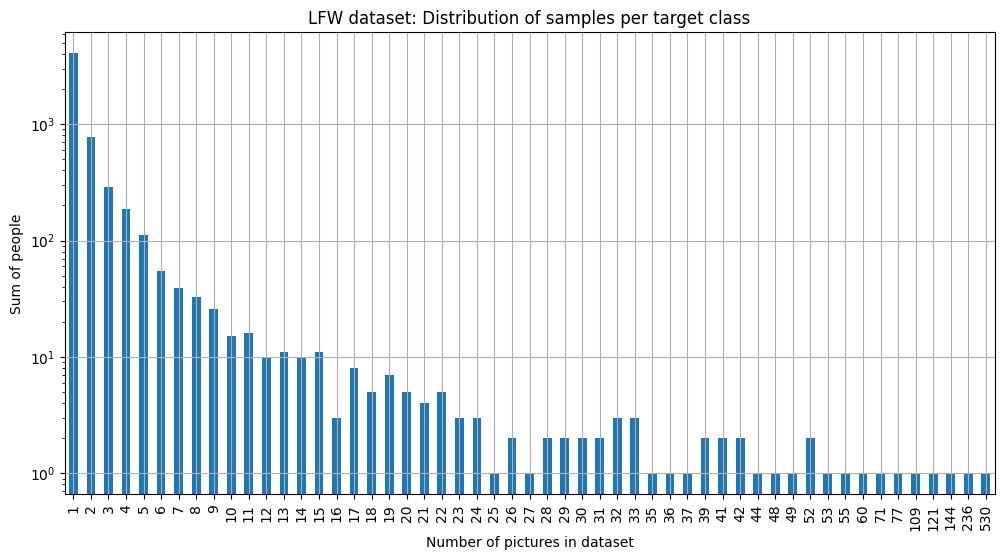

In [32]:
# --- Configuration and Data Loading ---
# Set the resize factor for images and minimum faces per person
RESIZE = 0.1   
min_faces = 0

# Fetch the LFW people dataset and transform into a DataFrame
lfw_people = fetch_lfw_people(min_faces_per_person=min_faces, resize=RESIZE, color=False)

# Extract image and label information
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# Create a DataFrame with the data and labels
df = pd.DataFrame(X[:n_samples])
df['target'] = y[:n_samples]
df['target_names'] = [target_names[i] for i in y[:n_samples]]

# Plot the distribution of samples per target class
df.value_counts('target').value_counts().sort_index().plot(
    logy=True,
    kind='bar',
    figsize=(12, 6), 
    title='LFW dataset: Distribution of samples per target class',
    xlabel='Number of pictures in dataset',
    ylabel='Sum of people',
    grid=True,
    )

In [33]:
# --- Configuration for LFW, PCA, and SVM ---
# Set the number of PCA components and minimum images per person
n_components = 360
min_faces = 60  # Minimum number of images per person
n_components = 360  # Number of PCA components
ROS = True  # Use RandomOverSampler for class balancing

<Axes: title={'center': 'LFW dataset: Distribution of samples per target class'}, xlabel='Number of pictures in dataset', ylabel='Sum of people'>

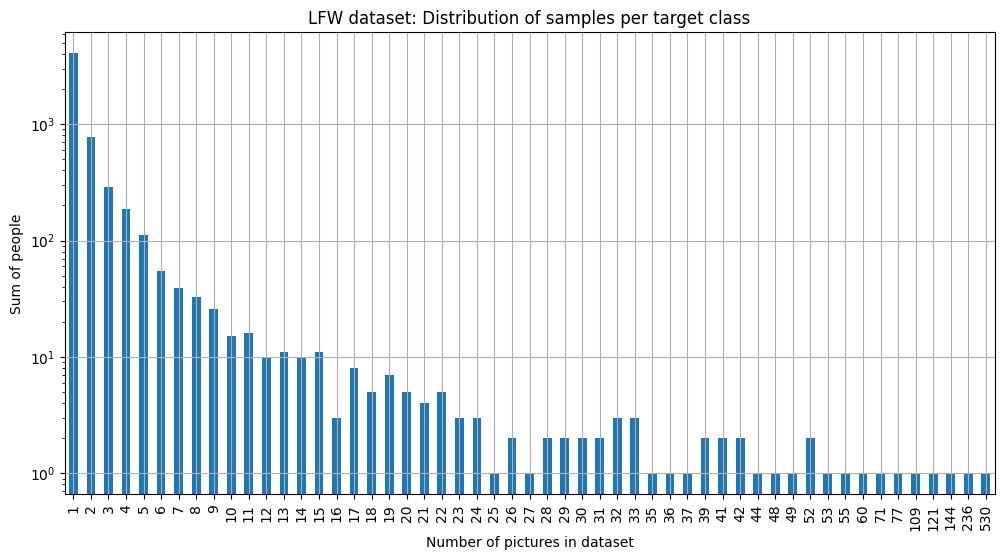

In [34]:
# --- Load the LFW dataset in color and print basic info ---
lfw_people = fetch_lfw_people(
    min_faces_per_person=min_faces,
    resize=0.8,
    color=True,
    download_if_missing=True,
)
# Extract data and labels for colored images
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
n_samples, h, w, c = lfw_people.images.shape

# Plot the distribution of samples per target class (again, for color images)
df.value_counts('target').value_counts().sort_index().plot(
    logy=True,
    kind='bar',
    figsize=(12, 6), 
    title='LFW dataset: Distribution of samples per target class',
    xlabel='Number of pictures in dataset',
    ylabel='Sum of people',
    grid=True,
    )

In [35]:
# --- Create dictionary for name-to-id mapping ---
# This allows easy lookup of person IDs by name for later use in analysis and plotting.
people_dict = {name: id for id, name in enumerate(lfw_people.target_names)}
people_list = [f'{id}: {name}' for id, name in enumerate(lfw_people.target_names)]

In [36]:
# --- Helper function: get dataset id of a person by name ---
def get_person_id(name: str) -> int:
    """
    Get the id of a person by their name.
    Args:
        name (str): Name of the person.
    Returns:
        int: id of the person.
    Raises:
        ValueError: if name is not found in the dataset.
    """
    # Lookup the person ID using the dictionary
    if name in people_dict:
        return people_dict[name]
    else:
        raise ValueError(f"Person {name} not found in dataset")

In [37]:
# --- More imports for ML pipeline ---
# Import PCA for dimensionality reduction, StandardScaler for feature scaling, and train_test_split for splitting data
from sklearn.decomposition import PCA  # Principal Component Analysis
from sklearn.preprocessing import StandardScaler  # Feature scaling
from sklearn.model_selection import train_test_split  # Train/test split

In [38]:
# --- Split data into train and test sets, apply oversampling if needed ---
# Split the data into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
if ROS:
    # Apply RandomOverSampler to balance the training set
    ros = RandomOverSampler(random_state=42)
    X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
    del X_train, y_train
    X_train = X_train_res.copy()
    y_train = y_train_res.copy()
    del X_train_res, y_train_res
    print('####### After ROS applied ########')
    unique, counts = np.unique(y_train, return_counts=True)
    print("Target distribution:")
    for label, count in zip(unique, counts):
        print(f"Target {label}: {count} Pictures")

####### After ROS applied ########
Target distribution:
Target 0: 432 Pictures
Target 1: 432 Pictures
Target 2: 432 Pictures
Target 3: 432 Pictures
Target 4: 432 Pictures
Target 5: 432 Pictures
Target 6: 432 Pictures
Target 7: 432 Pictures


In [39]:
# --- Standardize the data ---
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

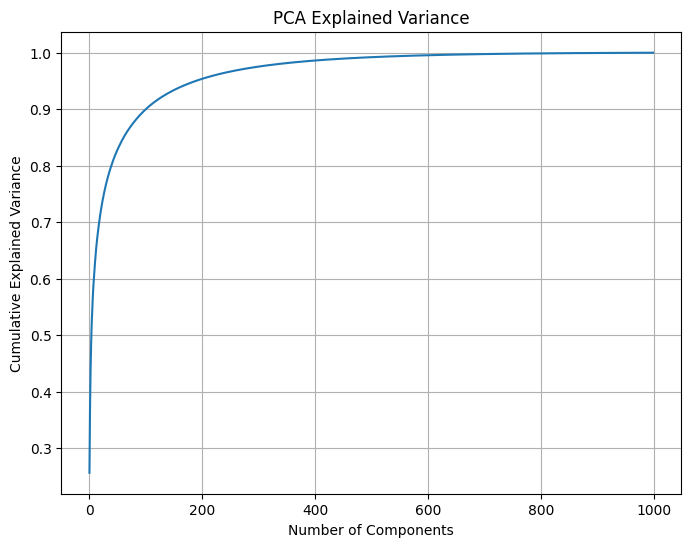

In [40]:
# --- Plot the PCA explained variance ratio ---
# Fit PCA to the training data and plot the cumulative explained variance
pca_plot_cev = PCA(n_components=1000, whiten=True, random_state=42).fit(X_train)
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca_plot_cev.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

In [41]:
# --- PCA on training data, then dimension reduction on training and test data ---
# Fit PCA on the training data and transform both train and test sets
pca = PCA(n_components=n_components, whiten=True, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [44]:
# --- More imports for evaluation ---
# Import metrics for classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

In [45]:
# --- Custom normalization for heatmap midpoint ---
from matplotlib.colors import Normalize

# --- Helper class for midpoint normalization in heatmaps ---
class MidpointNormalize(Normalize):
    """
    Normalizes the color scale so that a specified midpoint is at the center of the colormap.
    Useful for visualizing heatmaps with diverging color scales.
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [46]:
# --- Import for cosine similarity ---
# Import cosine_similarity for comparing feature vectors
from sklearn.metrics.pairwise import cosine_similarity

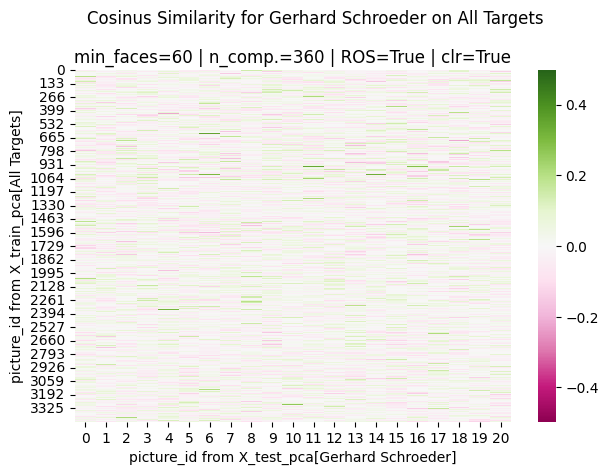

In [47]:
# --- Cosine similarity: Schroeder on all targets ---
# Compute cosine similarity between all training images and test images of 'Gerhard Schroeder'
person1 = 'Gerhard Schroeder'
cs_person_G = cosine_similarity(X_train_pca, X_test_pca[y_test == get_person_id(person1)])
# Plot the similarity matrix as a heatmap
sns.heatmap(cs_person_G, cmap='PiYG', vmin=-cs_person_G.max(), vmax=cs_person_G.max())
plt.suptitle(f'Cosinus Similarity for {person1} on All Targets')
plt.title(f'min_faces={min_faces} | n_comp.={n_components} | ROS={ROS} | clr={True}')
plt.xlabel(f'picture_id from X_test_pca[{person1}]')
plt.ylabel(f'picture_id from X_train_pca[All Targets]')
plt.tight_layout()
plt.show()

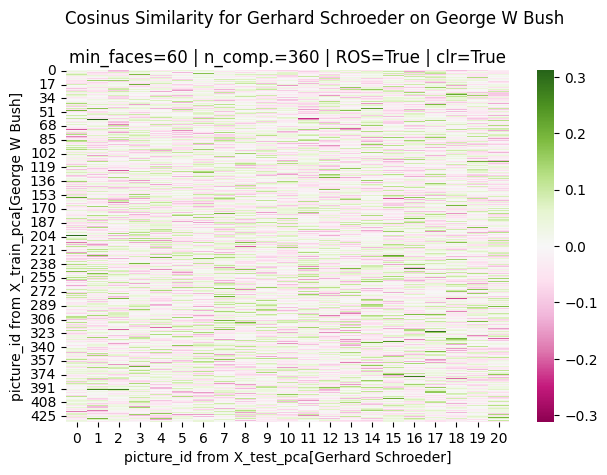

In [48]:
# --- Cosine similarity: Schroeder on George W Bush ---
# Compute cosine similarity between 'Gerhard Schroeder' (test) and 'George W Bush' (train)
person1 = 'Gerhard Schroeder'
person2 = 'George W Bush'
cs_person = cosine_similarity(X_train_pca[y_train == get_person_id(person2)], X_test_pca[y_test == get_person_id(person1)])
# Plot the similarity matrix as a heatmap
sns.heatmap(cs_person, cmap='PiYG', vmin=-cs_person.max(), vmax=cs_person.max())
plt.suptitle(f'Cosinus Similarity for {person1} on {person2}')
plt.title(f'min_faces={min_faces} | n_comp.={n_components} | ROS={ROS} | clr={True}')
plt.xlabel(f'picture_id from X_test_pca[{person1}]')
plt.ylabel(f'picture_id from X_train_pca[{person2}]')
plt.tight_layout()
plt.show()

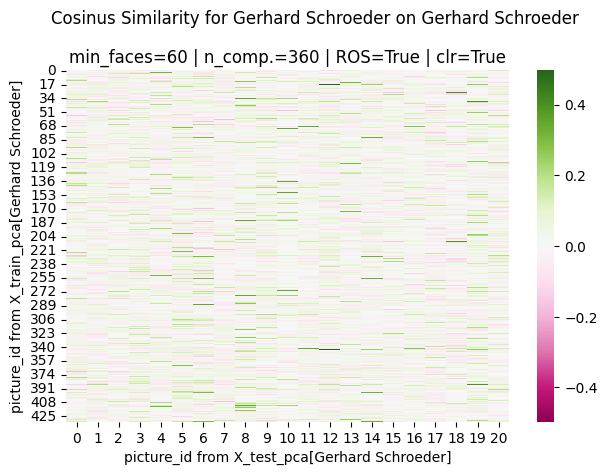

In [49]:
# --- Cosine similarity: Schroeder on Schroeder ---
# Compute cosine similarity between 'Gerhard Schroeder' (test) and 'Gerhard Schroeder' (train)
person1 = 'Gerhard Schroeder'
person2 = 'Gerhard Schroeder'
cs_person = cosine_similarity(X_train_pca[y_train == get_person_id(person2)], X_test_pca[y_test == get_person_id(person1)])
# Plot the similarity matrix as a heatmap
sns.heatmap(cs_person, cmap='PiYG', vmin=-cs_person.max(), vmax=cs_person.max())
plt.suptitle(f'Cosinus Similarity for {person1} on {person2}')
plt.title(f'min_faces={min_faces} | n_comp.={n_components} | ROS={ROS} | clr={True}')
plt.xlabel(f'picture_id from X_test_pca[{person1}]')
plt.ylabel(f'picture_id from X_train_pca[{person2}]')
plt.tight_layout()
plt.show()

IndexError: index 5 is out of bounds for axis 0 with size 5

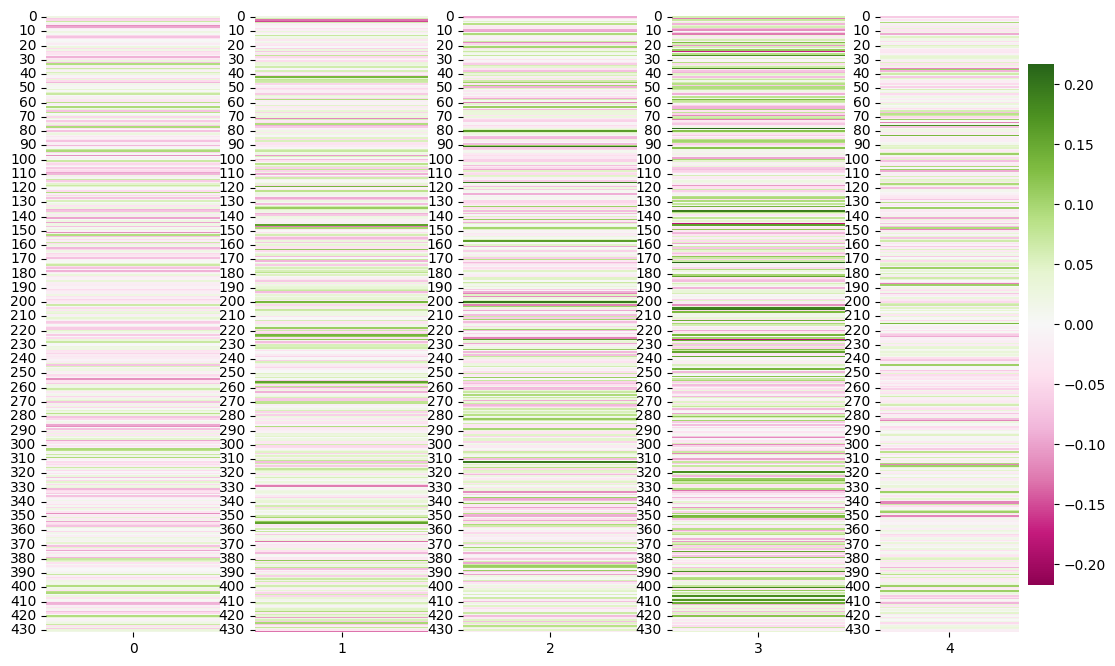

In [50]:
# --- Cosine similarity for a single test picture vs. all persons (subplot) ---
# Select a test picture index
pic = 99
cs_pic_person = []
# Compute cosine similarity between the selected test picture and all persons in the training set
for person in target_names:
    cs_pic_person.append(cosine_similarity(X_train_pca[y_train == get_person_id(person)], X_test_pca[pic].reshape(1, -1)))
# Prepare subplots for each person
fig, ax = plt.subplots(1, 5, figsize=(13, 8))
vmax = 0
# Find the maximum similarity value for color scaling
for i in range(len(target_names)):
    if max(cs_pic_person[i]) > vmax:
        vmax = max(cs_pic_person[i])
# Plot each person's similarity as a heatmap
for i in range(len(target_names)):
    cbar = (i == 4)
    sns.heatmap(data=cs_pic_person[i], xticklabels=f'{i}', cmap='PiYG', cbar=cbar, vmin=-vmax, vmax=vmax, ax=ax[i])
fig.suptitle(f'Cosinus Similarity for picture {pic}\n from X_test_pca')
fig.supxlabel(f'person_id')
ax[0].set_ylabel('picture_id from X_train_pca[person_id]')
plt.tight_layout()

In [51]:
# --- Import for accuracy score ---
# Import accuracy_score for model evaluation
from sklearn.metrics import accuracy_score

In [52]:
# --- Example: list of names (not used) ---
# This is a sample list of names for reference or testing
names = ['Colin Powell', 'Donald Rumsfeld', 'George W Bush', 'Gerhard Schroeder', 'Tony Blair']

<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
C:\Users\z\AppData\Local\Temp\ipykernel_9420\38616814.py:18: SyntaxWarning: invalid escape sequence '\s'
  plt.suptitle(f'Confusion Matrix:   $\sum CS_i$\nAccuracy = {accuracy_score(y_test, cs_pred)*100:.2f} %')


              precision    recall  f1-score   support

           0       0.83      0.83      0.83        12
           1       0.86      0.86      0.86        51
           2       0.88      0.88      0.88        25
           3       0.92      0.85      0.88        98
           4       0.72      0.86      0.78        21
           5       0.86      0.80      0.83        15
           6       0.62      1.00      0.77        10
           7       0.86      0.84      0.85        38

    accuracy                           0.86       270
   macro avg       0.82      0.87      0.84       270
weighted avg       0.86      0.86      0.86       270



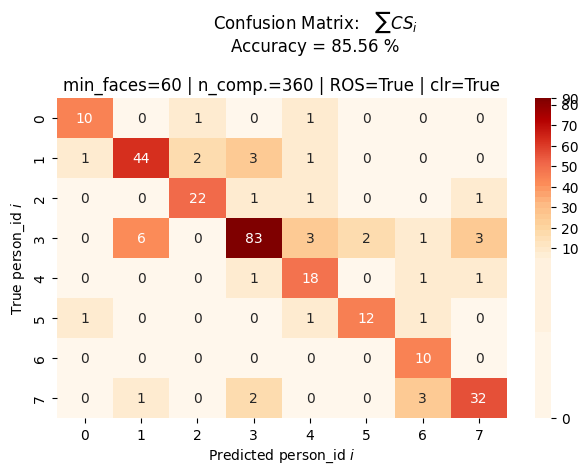

In [53]:
# --- Cosine similarity classification: sum of CS ---
# For each test image, compute the sum of cosine similarities to each class in the training set
cs_sum_test = np.empty(shape=(X_test_pca.shape[0], n_classes))
for picture in range(0, X_test_pca.shape[0]):
    cs_picture_sum = np.empty(shape=(0, n_classes))
    for person in range(0, n_classes):
        cs_picture_person = cosine_similarity(X_train_pca[y_train == person], X_test_pca[picture].reshape(1, -1))
        cs_picture_sum = np.append(cs_picture_sum, cs_picture_person.sum())
    cs_sum_test[picture] = cs_picture_sum
# Predict the class with the highest sum for each test image
cs_pred = []
for pic_id in range(cs_sum_test.shape[0]):
    for idx, value in np.ndenumerate(cs_sum_test[pic_id]):
        if value == max(cs_sum_test[pic_id]):
            cs_pred.append(idx[0])
# Plot the confusion matrix for the predictions
sns.heatmap(confusion_matrix(y_test, cs_pred), annot=True, norm=MidpointNormalize(vmin=0, midpoint=5), cmap='OrRd')
plt.suptitle(f'Confusion Matrix:   $\sum CS_i$\nAccuracy = {accuracy_score(y_test, cs_pred)*100:.2f} %')
plt.title(f'min_faces={min_faces} | n_comp.={n_components} | ROS={ROS} | clr={True}')
plt.xlabel('Predicted person_id $i$')
plt.ylabel('True person_id $i$')
plt.tight_layout()
print(classification_report(y_test, cs_pred))

<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
C:\Users\z\AppData\Local\Temp\ipykernel_9420\1899457876.py:18: SyntaxWarning: invalid escape sequence '\s'
  plt.suptitle(f'Confusion Matrix:   $\sum CS_i^3$\nAccuracy = {accuracy_score(y_test, cs_pred)*100:.2f} %')


              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       0.86      0.82      0.84        51
           2       0.87      0.80      0.83        25
           3       0.92      0.90      0.91        98
           4       0.63      0.81      0.71        21
           5       0.86      0.80      0.83        15
           6       0.91      1.00      0.95        10
           7       0.92      0.87      0.89        38

    accuracy                           0.86       270
   macro avg       0.83      0.85      0.84       270
weighted avg       0.87      0.86      0.86       270



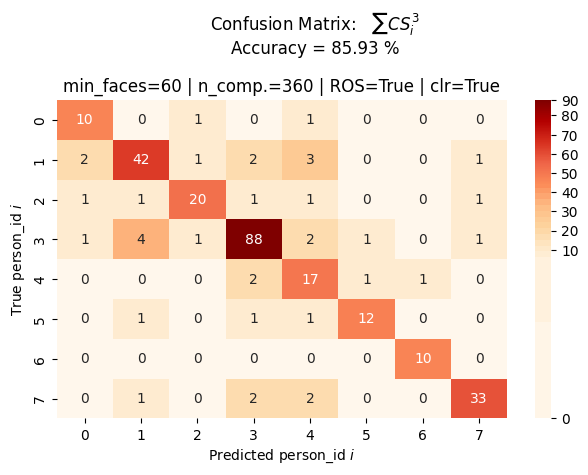

In [54]:
# --- Cosine similarity classification: sum of CS^3 ---
# For each test image, compute the sum of cubed cosine similarities to each class in the training set
cs_sum_test = np.empty(shape=(X_test_pca.shape[0], n_classes))
for picture in range(0, X_test_pca.shape[0]):
    cs_picture_sum = np.empty(shape=(0, n_classes))
    for person in range(0, n_classes):
        cs_picture_person = cosine_similarity(X_train_pca[y_train == person], X_test_pca[picture].reshape(1, -1)) ** 3
        cs_picture_sum = np.append(cs_picture_sum, cs_picture_person.sum())
    cs_sum_test[picture] = cs_picture_sum
# Predict the class with the highest sum for each test image
cs_pred = []
for pic_id in range(cs_sum_test.shape[0]):
    for idx, value in np.ndenumerate(cs_sum_test[pic_id]):
        if value == max(cs_sum_test[pic_id]):
            cs_pred.append(idx[0])
# Plot the confusion matrix for the predictions
sns.heatmap(confusion_matrix(y_test, cs_pred), annot=True, norm=MidpointNormalize(vmin=0, midpoint=5), cmap='OrRd')
plt.suptitle(f'Confusion Matrix:   $\sum CS_i^3$\nAccuracy = {accuracy_score(y_test, cs_pred)*100:.2f} %')
plt.title(f'min_faces={min_faces} | n_comp.={n_components} | ROS={ROS} | clr={True}')
plt.xlabel('Predicted person_id $i$')
plt.ylabel('True person_id $i$')
plt.tight_layout()
print(classification_report(y_test, cs_pred))